In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds_test, ds_test_info = tfds.load(
    'genomics_ood',
    split='test[:1000]',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train, ds_train_info = tfds.load(
    'genomics_ood',
    split='train[:100000]',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)



In [3]:
def tes(tensorA, b):
    to_fil = np.zeros(250)
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
        tensorA = tf.strings.regex_replace(tensorA, key, vocab[key])
    split = tf.strings.bytes_split(tensorA)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    tensorA = tf.one_hot(labels, 4)
    tensorA = tf.reshape(tensorA, (-1,))

    label = tf.one_hot(b, 10)
    return tensorA, label


In [4]:
ds_train = ds_train.shuffle(buffer_size=100000)
ds_train = ds_train.map(tes)
ds_train = ds_train.batch(32)
ds_train = ds_train.cache()

ds_test = ds_test.map(tes)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

model = tf.keras.Sequential(name="myModel")
model.add(tf.keras.Input(shape=(1000), name="Input"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_1"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_2"))
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name="otuput0"))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, name='SGD')
loss_fn = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
model.summary()

Model: "myModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 256)               256256    
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               65792     
_________________________________________________________________
otuput0 (Dense)              (None, 10)                2570      
Total params: 324,618
Trainable params: 324,618
Non-trainable params: 0
_________________________________________________________________


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
   print(e)

with tf.device("/device:GPU:0"):
    history = model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
3125/3125 [==============================] - 74s 24ms/step - loss: 2.1169 - accuracy: 0.2078 - val_loss: 1.7649 - val_accuracy: 0.2840
Epoch 2/10
3125/3125 [==============================] - 14s 4ms/step - loss: 1.6100 - accuracy: 0.3259 - val_loss: 1.5279 - val_accuracy: 0.3360
Epoch 3/10
3125/3125 [==============================] - 14s 4ms/step - loss: 1.5147 - accuracy: 0.3456 - val_loss: 1.4918 - val_accuracy: 0.3450
Epoch 4/10
3125/3125 [==============================] - 13s 4ms/step - loss: 1.4970 - accuracy: 0.3515 - val_loss: 1.4816 - val_accuracy: 0.3520
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 1.4907 - accuracy: 0.3556 - val_loss: 1.4773 - val_accuracy: 0.3540
Epoch 6/10
3125/3125 [==============================] - 13s 4ms/step - loss: 1.4872 - accuracy: 0.3577 - val_loss: 1.4750 - val_accuracy: 0.3540
Epoch 7/10
3125/3125 [==============================] - 13s 4ms/step - loss: 1.4846 - accuracy: 0.3591 - val_loss: 1.4735 - val_a

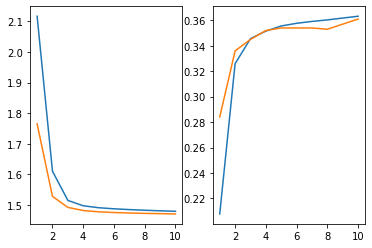

In [7]:
x_axis = np.arange(1, 11)


fig, ax = plt.subplots(1,2)
ax[0].plot(x_axis, history.history["loss"])
ax[0].plot(x_axis, history.history["val_loss"])
ax[1].plot(x_axis, history.history["accuracy"])
ax[1].plot(x_axis, history.history["val_accuracy"])
